# Data Analysis, RIT Business Competition

In [1]:
import folium
import requests
import json
import geojson
import numpy as np
import pandas as pd
import seaborn as sns
import typing
from datetime import datetime
from scipy.stats import percentileofscore
from matplotlib import pyplot as plt
from colorama import Fore


import warnings
from IPython.display import HTML, display
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data cleaning

### Shops data

In [2]:
df_info = pd.read_csv(r'pharm_info.csv')

In [3]:
df_info.head()

,storenum,storename,telephone,address1,address2,city,state,zipcode,zipcode4,longitude,latitude,website,orgname
0,2850.0,CVS - 1142,585-671-5665,1900 EMPIRE BOULEVARD,NaN,WEBSTER,NY,14580,1934.0,-77.501365,43.191229,HTTP://WWW.CVS.COM,CVS ALBANY LLC
1,2849.0,CVS - 2067,585-321-2581,2580 EAST HENRIETTA ROAD,NaN,ROCHESTER,NY,14623,4526.0,-77.606816,43.069235,HTTP://WWW.CVS.COM,CVS ALBANY LLC
2,2852.0,CVS - 2217,585-723-3051,878 LONG POND ROAD,NaN,GREECE,NY,14612,3049.0,-77.695905,43.238923,HTTP://WWW.CVS.COM,CVS ALBANY LLC
3,4603.0,CVS - 2218,585-581-5101,3750 MOUNT READ BOULEVARD,NaN,ROCHESTER,NY,14616,3436.0,-77.658331,43.227241,HTTP://WWW.CVS.COM,CVS ALBANY LLC
4,6057.0,CVS - 2501,585-426-2991,2709 CHILI AVENUE,NaN,ROCHESTER,NY,14624,4123.0,-77.709106,43.122328,HTTP://WWW.CVS.COM,CVS ALBANY LLC


In [4]:
#Dropping stores with no store numbers and coercing type
df_info = df_info.dropna(subset=['storenum'])

#Changing zipcode dtype
df_info['zipcode'] = df_info['zipcode'].astype(str)

In [5]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   storenum   69 non-null     float64
 1   storename  69 non-null     object 
 2   telephone  69 non-null     object 
 3   address1   69 non-null     object 
 4   address2   2 non-null      object 
 5   city       69 non-null     object 
 6   state      69 non-null     object 
 7   zipcode    69 non-null     object 
 8   zipcode4   69 non-null     float64
 9   longitude  69 non-null     float64
 10  latitude   69 non-null     float64
 11  website    69 non-null     object 
 12  orgname    69 non-null     object 
dtypes: float64(4), object(9)
memory usage: 7.5+ KB


In [6]:
#Dropping columns that I don't think will be useful for data analysis
df_info = df_info.drop(['telephone','address1','address2','state','website','zipcode4'],axis = 1)

In [7]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 0 to 68
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   storenum   69 non-null     float64
 1   storename  69 non-null     object 
 2   city       69 non-null     object 
 3   zipcode    69 non-null     object 
 4   longitude  69 non-null     float64
 5   latitude   69 non-null     float64
 6   orgname    69 non-null     object 
dtypes: float64(3), object(4)
memory usage: 4.3+ KB


### Sales data

In [8]:
df_sales = pd.read_csv(r'pharm_sales.csv')

In [9]:
#Changing date column to datetime object
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990746 entries, 0 to 990745
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   invnum                990746 non-null  object        
 1   date                  990746 non-null  datetime64[ns]
 2   storenum              990746 non-null  int64         
 3   vendornum             990745 non-null  float64       
 4   itemnum               990746 non-null  int64         
 5   itemcategory          990746 non-null  object        
 6   productcost           990746 non-null  float64       
 7   product_retail_price  990746 non-null  float64       
 8   units_sold            990746 non-null  int64         
 9   sales_num             990745 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 75.6+ MB


### Merging the two dataframes

In [10]:
#Merging both of them using the storenumber field as that is unique for stores.

df_merged = pd.merge(df_sales, df_info, on='storenum', how = 'outer')

### Renaming columns

In [11]:
df_merged = df_merged.rename(columns = {'sales_num':'revenue_original'})

In [12]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990746 entries, 0 to 990745
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   invnum                990746 non-null  object        
 1   date                  990746 non-null  datetime64[ns]
 2   storenum              990746 non-null  int64         
 3   vendornum             990745 non-null  float64       
 4   itemnum               990746 non-null  int64         
 5   itemcategory          990746 non-null  object        
 6   productcost           990746 non-null  float64       
 7   product_retail_price  990746 non-null  float64       
 8   units_sold            990746 non-null  int64         
 9   revenue_original      990745 non-null  float64       
 10  storename             990746 non-null  object        
 11  city                  990746 non-null  object        
 12  zipcode               990746 non-null  object        
 13 

In [13]:
# Dropping nulls
df_merged = df_merged.dropna()

df_merged = df_merged.reset_index(drop=True)

### Adding new fields and fixing types

In [14]:
# Original sales figures are off, this is probably a safer bet, might ignore taxes
df_merged['revenue_original'] = df_merged['product_retail_price'] * df_merged['units_sold']

# Total cost per sale.
df_merged['inventory_cost'] = df_merged['productcost'] * df_merged['units_sold']

# inventory costs are 68% of a businesses cost
#https://blog.shelvingdesignsystems.com/what-does-it-really-cost-to-start-a-pharmacy
df_merged['total_cost'] = df_merged['inventory_cost']/0.68

#Cost of non inventory overhead
df_merged['overhead_cost'] = df_merged['total_cost'] - df_merged['inventory_cost']

# Profit per sale
df_merged['profit'] = df_merged['revenue_original'] - df_merged['total_cost']

# Margin per unit
df_merged['margin'] = df_merged['product_retail_price'] - df_merged['productcost']

# Making store number field a string
df_merged['storenum'] = df_merged['storenum'].astype(str)


In [15]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990744 entries, 0 to 990743
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   invnum                990744 non-null  object        
 1   date                  990744 non-null  datetime64[ns]
 2   storenum              990744 non-null  object        
 3   vendornum             990744 non-null  float64       
 4   itemnum               990744 non-null  int64         
 5   itemcategory          990744 non-null  object        
 6   productcost           990744 non-null  float64       
 7   product_retail_price  990744 non-null  float64       
 8   units_sold            990744 non-null  int64         
 9   revenue_original      990744 non-null  float64       
 10  storename             990744 non-null  object        
 11  city                  990744 non-null  object        
 12  zipcode               990744 non-null  object        
 13 

#### The plot below will help me see whether I should worry too much about dropping shops or not.

If there is a huge range in variance between sales, then I should.

<AxesSubplot:xlabel='date'>

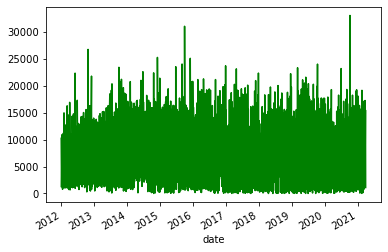

In [16]:
df_merged.groupby(['date'])['units_sold'].sum().plot(color = 'green')

Sale patterns are random, IE not that much yearly variation, thus I will drop pharmicies which made no sales in 2021, which I will assume is an indication for being closed.

### Dropping shops that probably closed.

Do we know the stores closed beyond a shadow of a doubt? No.


However doing any analysis would be moot if we don't have the data normalized in some way shape or form. It seems to me the best way to do that would be to normalize over a specific period of time. And to further normalize the data, I'll drop stores that did not have any sales past the year of 2021, then analyze with only those stores over a reasonable timeframe, where the loss of data wouldn't be too high.

In [17]:
#Making a new dataframe with only sales past 2021

df_merged_open = df_merged.loc[df_merged['date'] >= '2021-01-01']

df_merged_open = df_merged_open.reset_index(drop = True)

In [18]:
# Finding the shops that had sales in 2021, and keeping the values in a variable to assign to another dataframe later.

shops_still_open = df_merged_open['storenum'].unique()

shops_still_open

array(['3696', '2528', '5501', '5057', '5338', '5126', '2673', '4796',
       '5533', '4997', '4641', '2561', '4140', '5051', '2527', '4594',
       '2633', '2636', '2627', '4361', '2626', '4795', '5131', '2532',
       '5507', '5127', '5128', '4622', '2696', '4601', '4802', '4596',
       '5375', '4599', '4803', '4377', '4801', '4603', '5539', '2852',
       '2850', '3825', '4804', '4797', '4800', '5664', '4799', '2695',
       '5970', '5891', '6057', '6064'], dtype=object)

In [19]:
# Number of stores still open.

df_merged_open['storenum'].nunique()

52

In [20]:
52/69

0.7536231884057971

I lost 25% of the stores by only keeping the stores that were open in 2021, I need to see how much of the total dataset I will lose.

In [21]:
df_merged_final = df_merged[(df_merged['storenum'].isin(shops_still_open)) & (df_merged['date'] >= '2018-01-01')]

df_merged_final = df_merged_final.reset_index(drop = True)


In [22]:
df_info_final = df_info.loc[df_info['storenum'].isin(shops_still_open)]
df_info_final = df_info_final.reset_index(drop = True)

df_info_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   storenum   52 non-null     float64
 1   storename  52 non-null     object 
 2   city       52 non-null     object 
 3   zipcode    52 non-null     object 
 4   longitude  52 non-null     float64
 5   latitude   52 non-null     float64
 6   orgname    52 non-null     object 
dtypes: float64(3), object(4)
memory usage: 3.0+ KB


In [23]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371147 entries, 0 to 371146
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   invnum                371147 non-null  object        
 1   date                  371147 non-null  datetime64[ns]
 2   storenum              371147 non-null  object        
 3   vendornum             371147 non-null  float64       
 4   itemnum               371147 non-null  int64         
 5   itemcategory          371147 non-null  object        
 6   productcost           371147 non-null  float64       
 7   product_retail_price  371147 non-null  float64       
 8   units_sold            371147 non-null  int64         
 9   revenue_original      371147 non-null  float64       
 10  storename             371147 non-null  object        
 11  city                  371147 non-null  object        
 12  zipcode               371147 non-null  object        
 13 

In [24]:
# Saving as csv

#df_merged_final.to_csv('pharm_sales_final.csv')
#df_info_final.to_csv('pharm_info_final.csv')

# EDA

### Total sales over time

<AxesSubplot:title={'center':'Total units sold, time'}, xlabel='date'>

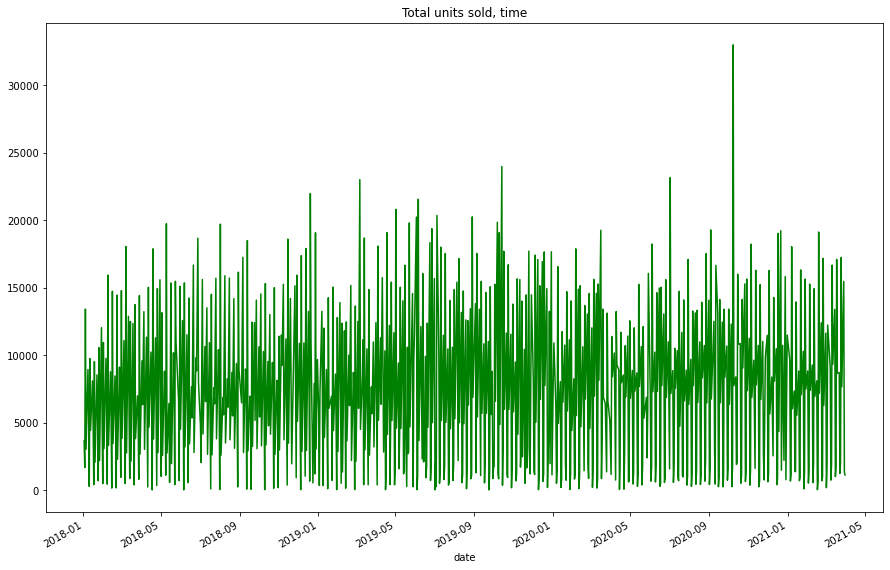

In [95]:
df_merged_final.groupby(['date'])['units_sold'].sum().plot(color = 'green', title = 'Total units sold, time')

## Zipcode

#### Profit

In [25]:
total_profit_zipcode_groups = df_merged_final.groupby(['zipcode']).sum().sort_values(['profit'], ascending = True)['profit']

total_profit_zipcode_groups.sort_values().head(10)

zipcode
14615     1307.171765
14467     1613.135294
14609     2322.936471
14625     2499.000588
14450     3041.305882
14611     3220.129412
14612     5725.337059
14607     6543.948824
14559     7186.052353
14526    11423.208824
Name: profit, dtype: float64

<AxesSubplot:title={'center':'Profit per zipcode'}, xlabel='zipcode', ylabel='Total ($) '>

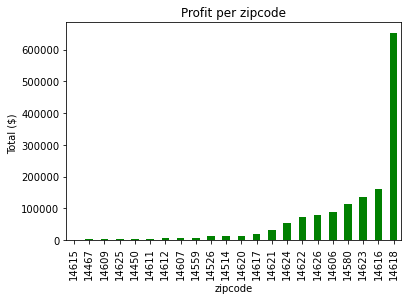

In [26]:
total_profit_zipcode_groups.plot(kind = 'bar',
                             color = 'green',
                            ylabel = 'Total ($) ',
                            title = 'Profit per zipcode')

In [27]:
number_stores_zipcode = df_info_final.groupby(['zipcode']).count()['storenum']

number_stores_zipcode.head(10)

zipcode
14450    1
14467    1
14514    2
14526    2
14559    1
14580    5
14606    3
14607    1
14609    2
14611    1
Name: storenum, dtype: int64

In [28]:
profit_per_zipcode = total_profit_zipcode_groups/number_stores_zipcode
profit_per_zipcode.sort_values().head()

zipcode
14609    1161.468235
14615    1307.171765
14467    1613.135294
14625    2499.000588
14612    2862.668529
dtype: float64

In [29]:
profit_per_zipcode.max()/profit_per_zipcode.mean()

12.17106385903507

<AxesSubplot:title={'center':'Average Profit/ Zipcode'}, xlabel='zipcode', ylabel='Total ($) '>

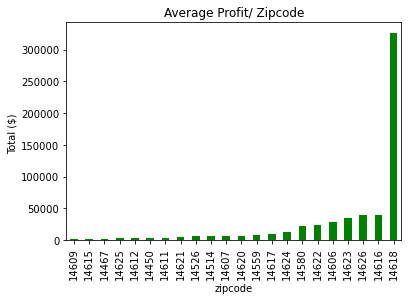

In [30]:
profit_per_zipcode.sort_values().plot(kind = 'bar',
                             color = 'green',
                            ylabel = 'Total ($) ',
                            title = 'Average Profit/ Zipcode')

## Choropleth map

In [31]:
# Link below has all the zipcode boundaries in NY state, I'll only keep the ones I need
url='https://github.com/OpenDataDE/State-zip-code-GeoJSON/raw/master/ny_new_york_zip_codes_geo.min.json'
gj =  requests.get(url).json()

In [32]:
# Making new geojson file
ziplist = df_merged_final['zipcode'].unique() #list of zips in your dataframe

inziplist = []
for  ft in gj['features']:
    if ft['properties']['ZCTA5CE10'] in ziplist:
        inziplist.append(ft)
        
new_zip_json = {}
new_zip_json['type'] = 'FeatureCollection'
new_zip_json['features'] = inziplist

In [33]:
#Turning the series above into a dataframe
df_zip = pd.DataFrame({'ZCTA5CE10': [x for x in profit_per_zipcode.index],
                       'average_profit': [x for x in profit_per_zipcode.values]})

# Casting type as string so that parser can parse connect it to geojson file
df_zip['ZCTA5CE10'] = df_zip['ZCTA5CE10']

m = folium.Map(location=[43.191229,-77.5], zoom_start=11, tile = 'stamenwatercolor')



style_function = "font-size: 15px; font-weight: bold"

choropleth = folium.Choropleth(
    geo_data = new_zip_json,
    name = "choropleth",
    data = df_zip,
    columns = ['ZCTA5CE10', 'average_profit'],
    key_on = 'feature.properties.ZCTA5CE10',
    fill_color = "YlGn",
    fill_opacity = 4,
    line_opacity = 2,
    legend_name = "Average profit",
    labels = True
).add_to(m)


# add labels indicating zipcode
style_function = "font-size: 15px; font-weight: bold"
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['ZCTA5CE10'], style=style_function, labels=False))


folium.LayerControl().add_to(m)

m

## Heatmap

In [34]:
df_zip = df_zip.rename(columns = {'ZCTA5CE10': 'zipcode', 'average_profit': 'AverageProfit'})
df_zip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   zipcode        22 non-null     object 
 1   AverageProfit  22 non-null     float64
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


In [147]:
df_demographics = pd.read_csv('zip_demographics.csv')

df_demographics['zipcode'] = df_demographics['zipcode'].astype(str)
df_demographics['PopulationDensity'] = df_demographics['CurrentPopulation']/df_demographics['Area']

df_demographics.head()

,zipcode,CurrentPopulation,RacialMajority,UnemploymentRate,MedianHouseholdIncome,AverageAdjustedGrossIncome,SchoolTestPerformance,Area,SchoolRacialMajority,SchoolRacialMajorityPercentage,RacialMajorityPercentage,PopulationDensity
0,14580,50587,White,5.3,75618.0,81510.0,Above Average,44.0,White,87.1,90.24,1149.704545
1,14623,27173,White,5.5,54283.0,49130.0,Above Average,20.0,White,56.0,71.17,1358.650000
2,14612,34515,White,7.3,62148.0,61510.0,Average,17.0,White,69.2,86.99,2030.294118
3,14616,28534,White,10.8,55438.0,46270.0,Above Average,6.0,White,67.2,82.20,4755.666667
4,14624,36296,White,6.5,69312.0,62360.0,Average,28.0,White,66.6,81.99,1296.285714


In [148]:
#Label encoding
encode_dict = {"SchoolTestPerformance":     {'Poor': 1, 'Below Average': 2, 'Average':3,
                                            'Above Average':4, 'Excellent':5},"RacialMajority": {'White': 0, 'Black':1}}

df_demographics = df_demographics.replace(encode_dict)


In [149]:
df_demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   zipcode                         25 non-null     object 
 1   CurrentPopulation               25 non-null     int64  
 2   RacialMajority                  25 non-null     int64  
 3   UnemploymentRate                25 non-null     float64
 4   MedianHouseholdIncome           25 non-null     float64
 5   AverageAdjustedGrossIncome      25 non-null     float64
 6   SchoolTestPerformance           25 non-null     int64  
 7   Area                            25 non-null     float64
 8   SchoolRacialMajority            25 non-null     object 
 9   SchoolRacialMajorityPercentage  25 non-null     float64
 10  RacialMajorityPercentage        25 non-null     float64
 11  PopulationDensity               25 non-null     float64
dtypes: float64(7), int64(3), object(2)
mem

In [150]:
df_zips_merged = pd.merge(df_demographics, df_zip, on='zipcode', how = 'outer')
df_zip_num = df_zips_merged.select_dtypes(include = ['float64', 'int64'])

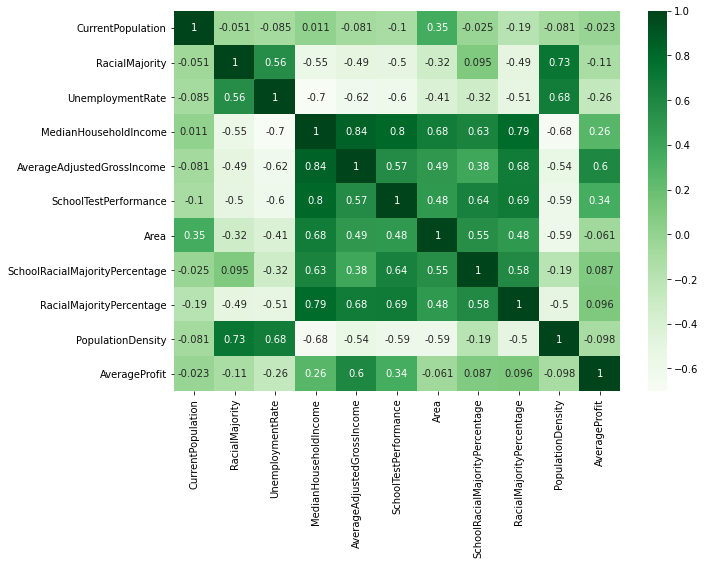

In [153]:
plt.rcParams['figure.figsize'] = [10,7]
ax = sns.heatmap(df_zip_num.corr(), annot=True, cmap = "Greens")

## Store , most profitible

In [40]:
total_profit_store_num = df_merged_final.groupby(['storenum']).sum().sort_values(['profit'], ascending = True)['profit']

total_profit_store_num.sort_values().head()

#Keep 4641 in mind

storenum
5970     257.497647
6064     328.004706
2695     486.239412
2696    1270.866471
5891    1307.171765
Name: profit, dtype: float64

In [41]:
total_profit_store_num.describe()

count        52.000000
mean      28282.520667
std       90299.770394
min         257.497647
25%        3175.423529
50%        6484.453824
75%       18233.935441
max      646563.885882
Name: profit, dtype: float64

<AxesSubplot:title={'center':'Profit / Store (number)'}, xlabel='storenum', ylabel='Total ($) '>

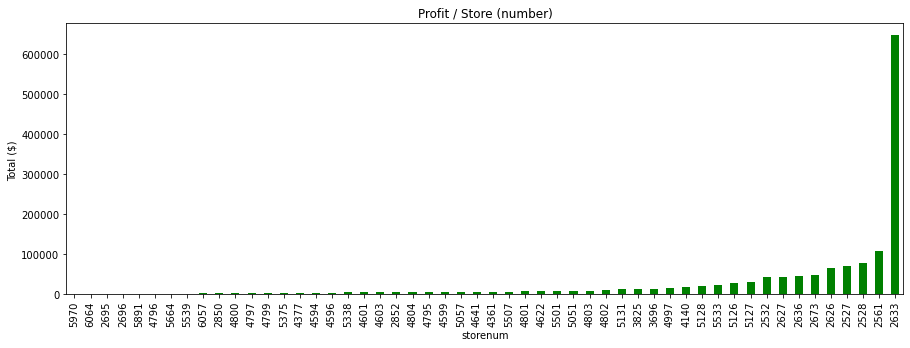

In [42]:
total_profit_store_num.sort_values().plot(kind = 'bar',
                             color = 'green',
                            ylabel = 'Total ($) ',
                            title = 'Profit / Store (number)',
                                         figsize = (15,5))

<AxesSubplot:title={'center':'Profit distribution (shops)'}, ylabel='Density'>

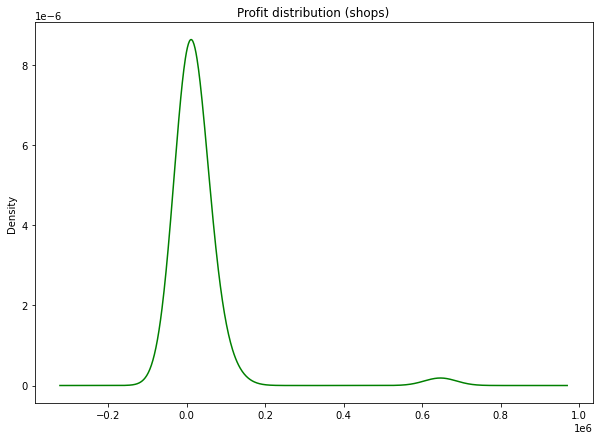

In [43]:
total_profit_store_num.plot.kde(color = 'green', title = 'Profit distribution (shops)')

## Most profitible products & product sets

#### Top 500 profitible

In [44]:
profit_products = df_merged_final.groupby(['itemnum'])['profit'].sum().sort_values().tail(500)

profit_products_set = set(np.array(profit_products.index))

#numpy arrays for well formatted output
np.array(profit_products.index)[0:100]

array([ 36967,  64513,  34787,  42703,  34819,  81208,  81124,  48107,
        88018,  52314,  36447,  11588,   5696,  43136, 918010,  34003,
        77714,  80456,  33663,  15582,  57125,  59154,   5446,  43051,
        27780,   5347,  19063,  77632,  82147,  43387,  68340,  10548,
        34014,  43095,  34116,  82636,  87589,  37346,  65200,  37886,
        35354,  35416,  65258,  36900,  76478, 989646,  34881,  89215,
       100413,  89445,  17766,  86691,  12408,  27605,  27544,  38179,
        21596,   5006,  43244,  22786,  89200,  22228,  36989,   5430,
        33658, 101187,  27410,  89121,  52318,  77852,  44658,  68022,
        37665,  89796,  64996,  82846,  77709,  58875,  87511,  32238,
        89242,  43038,  74801,  77776,  57051,  44419, 989653,  36618,
        52593,  34579,  29119,   5635,  89786,  86796,  28086, 916850,
        43328,  77842,  87280,  43121], dtype=int64)

#### Products available in 4641

In [45]:
products_4641_set = set(df_merged_final.loc[df_merged_final['storenum'] == '4641']['itemnum'].unique())

np.array(products_4641_set)

array({11776, 11777, 25604, 34820, 25606, 36873, 36875, 11788, 36878, 43025, 43026, 43028, 19476, 11290, 11294, 11296, 36904, 43050, 43051, 10802, 10803, 10805, 10807, 39492, 77903, 36965, 89191, 36968, 36969, 37991, 36971, 37996, 37994, 37998, 89194, 89196, 43121, 89199, 28275, 12404, 19061, 43126, 34423, 19064, 28279, 12408, 19066, 43124, 38008, 43125, 43136, 34433, 27780, 77956, 40070, 27783, 40592, 40593, 40594, 37012, 86691, 86692, 38056, 100015, 39419, 17086, 26820, 26821, 26824, 26826, 84172, 34001, 34004, 34006, 42716, 41693, 45276, 72928, 65251, 88294, 65254, 65256, 88296, 26858, 31474, 31475, 78078, 78079, 40192, 43777, 1799, 15626, 46350, 43285, 38174, 38176, 38178, 38180, 38194, 81204, 10550, 81206, 17206, 43331, 43334, 43336, 43338, 88406, 64858, 73055, 64864, 64863, 64866, 52579, 86884, 86885, 86886, 64870, 64865, 87403, 87408, 52594, 52596, 77714, 27544, 68009, 77740, 75183, 28081, 86456, 75208, 36301, 36304, 36306, 36308, 68052, 58838, 66518, 26585, 37338, 53214, 27102,

In [232]:
len(products_4641_set)

159

In [46]:
reccomended_products_set = profit_products_set - products_4641_set

total_set_4641 = products_4641_set | reccomended_products_set

np.array(reccomended_products_set)

array({34819, 34821, 69637, 36874, 77842, 77843, 36886, 36887, 69657, 43036, 77852, 43038, 49185, 49186, 36900, 49189, 36903, 36908, 88116, 34871, 100413, 34881, 100423, 26710, 43095, 86112, 36967, 36970, 36974, 36976, 43120, 36978, 41077, 43127, 43128, 88186, 36989, 43137, 34972, 34995, 45248, 28866, 28867, 26823, 84171, 26828, 26827, 45277, 45278, 82147, 88298, 86251, 43244, 22784, 22786, 4356, 22788, 266, 16676, 10548, 43316, 69946, 69947, 43328, 43333, 43337, 74086, 45419, 43387, 10627, 10628, 37258, 27025, 27026, 68022, 29119, 68036, 68037, 989646, 16850, 989653, 37336, 88536, 37346, 37347, 88548, 37348, 88556, 35314, 35316, 35317, 35318, 918010, 4626, 35354, 10784, 10791, 10792, 37418, 10804, 10808, 12856, 10809, 80456, 35416, 35418, 29287, 19063, 19067, 8828, 19068, 41604, 64136, 86670, 86672, 64147, 86693, 47786, 82607, 33467, 76478, 17087, 82627, 76487, 82636, 82637, 41692, 41694, 17127, 41705, 68340, 4866, 4867, 86796, 27410, 19226, 37663, 37665, 27433, 72504, 27453, 45886, 1

In [47]:
products_2633_set = set(df_merged_final.loc[df_merged_final['storenum'] == '2633']['itemnum'].unique())

In [48]:
def colors_256(color_):
    
    num1 = str(color_)
    num2 = str(color_).ljust(3, ' ')
    
    if color_ % 16 == 0:
        return(f"\033[38;5;{num1}m {num2} \033[0;0m\n")
    else:
        return(f"\033[38;5;{num1}m {num2} \033[0;0m")

x = '{'+ ','.join([Fore.RED + str(x) if x in products_2633_set else str(x) for x in total_set_4641]) + '}'
x = x.replace(' ', '')

print(x)

{34819,34820,34821,69637,36873,36874,36875,36878,43025,43026,77842,43028,77843,36886,36887,69657,43036,77852,43038,49185,49186,36900,49189,36903,36904,43050,43051,36908,88116,34871,100413,34881,100423,77903,26710,43095,86112,36965,36967,36968,36969,36970,36971,36974,36976,43121,43120,36978,12404,43124,43126,43125,12408,41077,43127,43128,88186,36989,43136,43137,77956,37012,34972,34995,45248,28866,28867,26820,26821,26823,26824,26826,84171,84172,26828,26827,45276,45277,45278,82147,88294,88296,26858,88298,86251,43244,78078,78079,22784,22786,4356,22788,266,43285,16676,10548,43316,10550,69946,69947,43328,43331,43333,43334,43336,43337,43338,88406,74086,45419,43387,10627,10628,37258,27025,27026,68009,68022,86456,29119,68036,68037,989646,16850,68052,989653,37336,88536,37338,27102,37346,37347,88548,37348,88556,35314,35316,27125,35317,35318,918010,39419,4626,35354,10784,10791,10792,37418,10802,10803,10804,10805,10807,10808,12856,10809,39492,80456,35416,35418,29287,19061,19063,19064,19066,19067,88

## Shop reccomendations

### Pre-eliminary calculations

In [49]:
stores_14618 = df_merged_final.loc[df_merged_final['zipcode'] == '14618' ]['storenum'].unique()
stores_14618

array(['4641', '2633'], dtype=object)

In [50]:
total_profit_store_num['4641'] #61.5th percentile

6469.285882352976

In [51]:
percentile_of_4641 = percentileofscore(total_profit_store_num, total_profit_store_num['4641'])
percentile_of_4641

50.0

### Helper functions

In [52]:
def sale_timedelta(storenumber,df):
    # Returns number of days between first and last sale in specific shops
    
    start = df.loc[df['storenum'] == storenumber]['date'].describe()['first']
    stop = df.loc[df['storenum'] == storenumber]['date'].describe()['last']

    return int((stop-start).days)

sale_timedelta('4641',df_merged_final)

1179

In [53]:
# All unique stores.
storenums = df_merged_final['storenum'].unique()
storenums

array(['3696', '2528', '5501', '5057', '5338', '5126', '2673', '4796',
       '5533', '4997', '4641', '2561', '4140', '5051', '2527', '4594',
       '2633', '2636', '2627', '4361', '2626', '4795', '5131', '2532',
       '5507', '5127', '5128', '4622', '2696', '4601', '4802', '4596',
       '5375', '4599', '4803', '4377', '4801', '4603', '5539', '2852',
       '2850', '3825', '4804', '4797', '4800', '5664', '4799', '2695',
       '5970', '5891', '6057', '6064'], dtype=object)

In [54]:
# Getting time delta of all stores
stores_daysdelta_list = np.array([(store,sale_timedelta(store,df_merged_final)) for store in storenums])

In [55]:
stores_daysdelta_list[0:5]

array([['3696', '1182'],
       ['2528', '1180'],
       ['5501', '1176'],
       ['5057', '1178'],
       ['5338', '1173']], dtype='<U4')

In [56]:
#Turning array to series, for index matching
idx, values = zip(*stores_daysdelta_list)

stores_timedelta_series = pd.Series((int(x) for x in values), idx)

In [57]:
# Finding profit per day
store_profit_perday= total_profit_store_num/stores_timedelta_series

store_profit_perday.sort_values().tail()

2626     54.743972
2527     60.304628
2528     65.689499
2561     90.813035
2633    546.545973
dtype: float64

In [58]:
for index in store_profit_perday.tail().index:
    print(store_profit_perday[index])

2.189442190669386
3.458126361655788
0.8909953185426444
10.059784313725558
3.904817927170887


### Comparison plots

In [176]:
# class else write 100 lines of code
class Option:
    def __init__(self, name: str,cost: float,daily_profit: float,fixed_cost: float,n: int,days: int,investment: bool):

        self.name = name
        self.cost = cost
        self.daily_profit = daily_profit
        self.fixed_cost = fixed_cost
        self.n = n
        self.days = days
        self.investment = investment

    def cashplot(self):
        if self.n != 1 or self.n != 0:
            self.cost = (self.cost*self.n)-(self.fixed_cost*(self.n-1))
            self.daily_profit = self.daily_profit*self.n


        cashsum_pharmacy = 0
        pharmacy_profit = [self.daily_profit for i in range(1,self.days)]
        pharmacy_cash = np.append([self.cost+self.daily_profit],pharmacy_profit) if self.investment \
        else np.append([-self.cost+self.daily_profit],pharmacy_profit)

        summed_list = []
        for v in pharmacy_cash:
            cashsum_pharmacy += v
            summed_list.append(cashsum_pharmacy)

        return summed_list
    
    def breakeven(self):
        if self.investment:
            return 0
        return self.cost//self.daily_profit
        

    def profit(self):
        if self.investment:
            return self.cashplot()[-1] - self.cost
        return self.cashplot()[-1]
    
    def plot(self):
        interval = range(1,self.days+1)
        plt.rcParams['figure.figsize'] = [15, 10] 
        plt.plot(interval, self.cashplot(), label=self.name)
        plt.ylabel('$')
        plt.xlabel('days')
        plt.title('Net positive cashflow over 10 years')
        plt.legend()
        plt.grid(True)

In [302]:
consise_list = []

consise_list.append(Option('Buy 4641',0,store_profit_perday['4641'],0,1,3650,False))
consise_list.append(Option('Building pharmacy',0,store_profit_perday.mean(),0,1,3650,False))

In [303]:
store_profit_perday.mean()

24.31777582684731

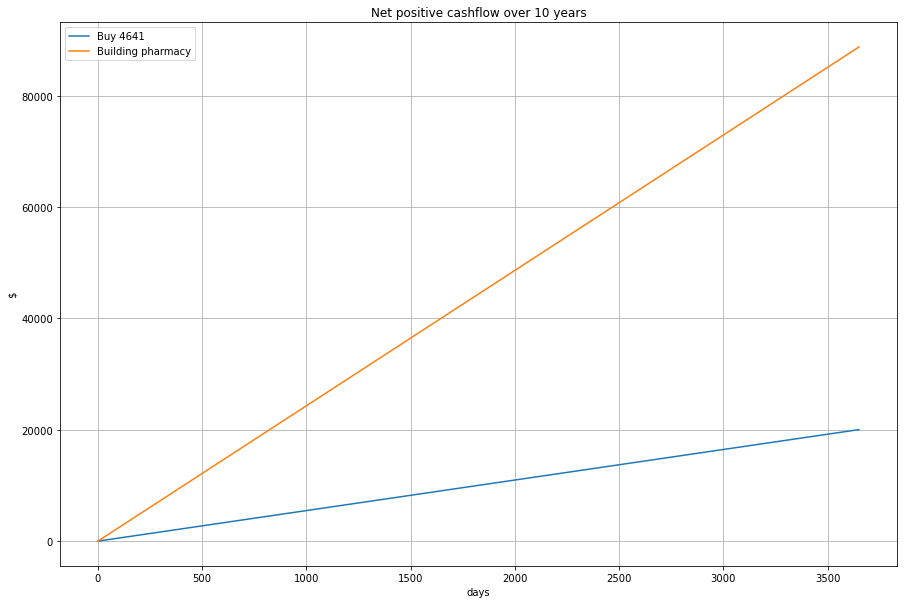

In [304]:
for v in consise_list:
    v.plot()

## Vendors

<AxesSubplot:xlabel='vendornum'>

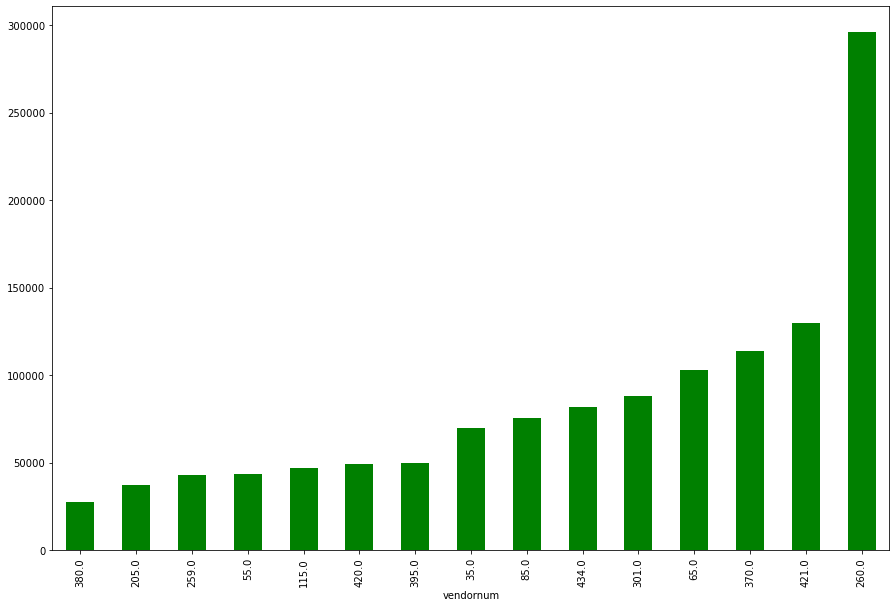

In [324]:
df_merged_final.groupby(['vendornum'])\
.sum().sort_values(['profit'], ascending = True)['profit'].tail(15)\
.plot(kind = 'bar',color = 'green')

In [346]:
df_4641['vendornum'].nunique()

26

In [325]:
161*0.2

32.2

In [327]:
vendors = df_merged_final.groupby(['vendornum'])\
.sum().sort_values(['profit'], ascending = True)['profit'].tail(64)\

np.array(vendors.index)

array([479., 357., 342., 216., 497., 285., 308., 482., 564., 239., 557.,
       287., 267., 451., 391., 978., 116.,  91., 402., 384., 306., 214.,
       469., 346., 521., 130., 566., 184., 368., 492., 195., 154., 266.,
       297., 322., 277., 125., 619., 461., 330., 305., 626., 229., 389.,
       240., 255., 192., 300., 410., 380., 205., 259.,  55., 115., 420.,
       395.,  35.,  85., 434., 301.,  65., 370., 421., 260.])

In [341]:
vendors_4641 = set(df_4641['vendornum'].unique())

In [344]:
np.array(set(vendors.index) | vendors_4641)

array({259.0, 260.0, 521.0, 266.0, 267.0, 277.0, 285.0, 287.0, 35.0, 297.0, 300.0, 557.0, 301.0, 305.0, 306.0, 308.0, 564.0, 566.0, 55.0, 65.0, 322.0, 330.0, 85.0, 342.0, 346.0, 91.0, 357.0, 619.0, 368.0, 626.0, 115.0, 116.0, 370.0, 380.0, 125.0, 384.0, 130.0, 389.0, 391.0, 395.0, 402.0, 154.0, 410.0, 420.0, 421.0, 434.0, 184.0, 192.0, 451.0, 195.0, 461.0, 205.0, 978.0, 469.0, 214.0, 216.0, 479.0, 482.0, 229.0, 492.0, 239.0, 240.0, 497.0, 255.0},
      dtype=object)

## Random calculations

In [278]:
stores_perzipcode = df_info_final.groupby(['zipcode'])['storenum'].count()

area_zipcode = df_demographics.groupby(['zipcode']).first()['Area']

store_perarea = stores_perzipcode/area_zipcode

store_perarea.corr(profit_per_zipcode, method= 'pearson')

-0.05322828236009978

In [279]:
df_4641 = df_merged_final.loc[(df_merged_final['storenum'] == '4641') & (df_merged_final['date'] <= '2021-01-01')]
df_4641.head()

,invnum,date,storenum,vendornum,itemnum,itemcategory,productcost,product_retail_price,units_sold,revenue_original,...,city,zipcode,longitude,latitude,orgname,inventory_cost,total_cost,overhead_cost,profit,margin
75633,INV-25073100004,2020-02-07,4641,259.0,11776,OTC/VMS,5.23,7.85,12,94.20,...,ROCHESTER,14618,-77.560946,43.123848,CVS ALBANY LLC,62.76,92.294118,29.534118,1.905882,2.62
75634,INV-25073100005,2020-02-07,4641,260.0,37996,OTC/VMS,8.25,12.38,12,148.56,...,ROCHESTER,14618,-77.560946,43.123848,CVS ALBANY LLC,99.00,145.588235,46.588235,2.971765,4.13
75635,INV-25073100010,2020-02-07,4641,259.0,11788,Personal hygiene,10.45,15.68,6,94.08,...,ROCHESTER,14618,-77.560946,43.123848,CVS ALBANY LLC,62.70,92.205882,29.505882,1.874118,5.23
75636,INV-25073100003,2020-02-07,4641,421.0,86884,Skin care items,4.78,7.17,10,71.70,...,ROCHESTER,14618,-77.560946,43.123848,CVS ALBANY LLC,47.80,70.294118,22.494118,1.405882,2.39
75637,INV-25073100008,2020-02-07,4641,192.0,65254,Skin care items,6.52,9.78,10,97.80,...,ROCHESTER,14618,-77.560946,43.123848,CVS ALBANY LLC,65.20,95.882353,30.682353,1.917647,3.26


In [280]:
df_4641['month'] = df_4641['date'].dt.month

<ipython-input-280-27bfb62656d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4641['month'] = df_4641['date'].dt.month


In [281]:
df_4641['month']

75633     2
75634     2
75635     2
75636     2
75637     2
         ..
79276    12
79277    12
79278    12
79279    12
79280    12
Name: month, Length: 3648, dtype: int64

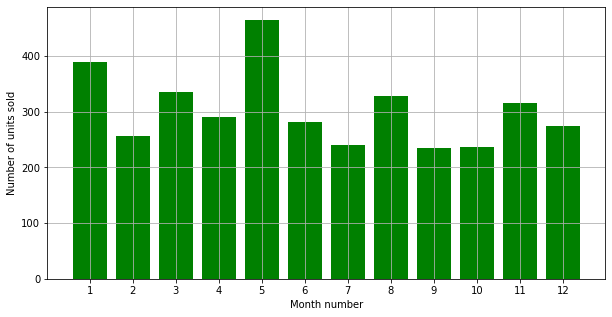

In [286]:
months = range(1,13)

plt.rcParams['figure.figsize'] = [10, 5]
plt.bar(months,df_4641.groupby(['month']).count()['itemnum'],color = 'green')
plt.xticks(months)
plt.ylabel('Number of units sold')
plt.xlabel('Month number')
plt.grid()
plt.show()

In [287]:
store_profit_perday.describe()

count     52.000000
mean      24.317776
std       76.238075
min        0.857565
25%        3.417513
50%        5.538680
75%       15.509820
max      546.545973
dtype: float64

In [288]:
percentileofscore(store_profit_perday, store_profit_perday['4641'])

48.07692307692308